import and pip necessary libraries

In [17]:
import pandas as pd 
import time
import matplotlib.pyplot as plt
import numpy as np

! pip install scikit-surprise
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import SVD, SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [18]:
filtered_data = pd.read_csv("filtered_data.csv")
filtered_data.head() 

,userId,productId,rating,timestamp
0,AO94DHGC771SJ,0528881469,5.0,1370131200
1,AMO214LNFCEI4,0528881469,1.0,1290643200
2,A3N7T0DY83Y4IG,0528881469,3.0,1283990400
3,A1H8PY3QHMQQA0,0528881469,2.0,1290556800
4,A24EV6RXELQZ63,0528881469,1.0,1317254400


In [19]:
# Display dataset information and basic statistics
print(filtered_data.info())
print(filtered_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991560 entries, 0 to 1991559
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 60.8+ MB
None
             rating     timestamp
count  1.991560e+06  1.991560e+06
mean   4.201605e+00  1.339592e+09
std    1.205818e+00  6.520485e+07
min    1.000000e+00  9.292320e+08
25%    4.000000e+00  1.316909e+09
50%    5.000000e+00  1.360714e+09
75%    5.000000e+00  1.385078e+09
max    5.000000e+00  1.406074e+09


Data Preprocess

In [4]:
sample_fraction = 0.1
sample_data = filtered_data.sample(frac=sample_fraction)

In [5]:
sample_data

,userId,productId,rating,timestamp
1464293,A3AEDUJ7MXBNEX,B006U1YUW2,5.0,1376006400
241262,AE2GD378S55XK,B000EXRSVM,1.0,1187308800
831788,A13J19NEY58PM8,B00346I5LI,5.0,1315267200
301016,A5FQY9IUK3P3L,B000KHPIO6,3.0,1302566400
671988,A242ZSXKJLL4FM,B0027M4CX0,5.0,1396051200
...,...,...,...,...
218976,A3HG3FXG1GTWU4,B000CKVOOY,4.0,1366588800
966152,A1FHU6UUI9S0WM,B003TQ1010,4.0,1374105600
1164849,A3C3PPYKBW2G5Q,B004NBZ98K,5.0,1359417600
46965,A3S3MOT7JM82FA,B00006B9CR,4.0,1305849600


Item-Item Collaborative Filtering model

Transfer data into Surprise format, and split train and test data

In [7]:
reader = Reader(rating_scale=(1, 5))

surprise_data = Dataset.load_from_df(filtered_data[['userId', 'productId', 'rating']], reader)
surprise_subsetdata = Dataset.load_from_df(sample_data[['userId', 'productId', 'rating']], reader)

SVD and SVD++

In [7]:
# Record the start time
start_time = time.time()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_epochs': [5, 10, 15, 20],
    'lr_all': [0.002, 0.005, 0.008],
    'reg_all': [0.2, 0.4, 0.6]
}

# Perform GridSearchCV for SVD
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_svd.fit(surprise_subsetdata)

# Print the best parameters for SVD
print("Best parameters for SVD: ", grid_search_svd.best_params['rmse'])

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Best parameters for SVD:  {'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.4}
Elapsed time: 781.98 seconds


In [8]:
# Record the start time
start_time = time.time()

# Perform GridSearchCV for SVD++
grid_search_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_svdpp.fit(surprise_subsetdata)

# Print the best parameters for SVD++
print("Best parameters for SVD++: ", grid_search_svdpp.best_params['rmse'])

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Best parameters for SVD++:  {'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.4}
Elapsed time: 788.84 seconds


In [9]:
# Record the start time
start_time = time.time()

# Cross-validate the best SVD model
best_svd = SVD(**grid_search_svd.best_params['rmse'])
cv_results_svd = cross_validate(best_svd, surprise_data, measures=['rmse', 'mae'], cv=5, verbose=True)

# Cross-validate the best SVD++ model
best_svdpp = SVDpp(**grid_search_svdpp.best_params['rmse'])
cv_results_svdpp = cross_validate(best_svdpp, surprise_data, measures=['rmse', 'mae'], cv=5, verbose=True)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1091  1.1123  1.1114  1.1069  1.1112  1.1102  0.0019  
MAE (testset)     0.8372  0.8398  0.8391  0.8368  0.8380  0.8382  0.0011  
Fit time          86.60   87.80   87.17   87.20   86.93   87.14   0.39    
Test time         5.09    4.59    5.03    4.45    4.42    4.72    0.29    
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1123  1.1077  1.1079  1.1091  1.1089  1.1092  0.0017  
MAE (testset)     0.8386  0.8352  0.8361  0.8368  0.8371  0.8367  0.0011  
Fit time          334.37  330.73  332.79  330.85  340.75  333.90  3.68    
Test time         12.08   11.21   12.13   12.06   11.80   11.85   0.34    
Elapsed time: 2247.21 seconds


In [14]:
import pickle

best_svd.fit(surprise_data.build_full_trainset())
best_svdpp.fit(surprise_data.build_full_trainset())

# Save the best SVD model
with open("best_svd_model.pkl", "wb") as f:
    pickle.dump(best_svd, f)

# Save the best SVD++ model
with open("best_svdpp_model.pkl", "wb") as f:
    pickle.dump(best_svdpp, f)

Basic KNN and KNN Baseline

In [6]:
# Record the start time
start_time = time.time()

# Parameter grid for KNNBasic and KNNWithMeans
param_grid = {
    'k': [10, 20, 30, 40, 50]
}

# Perform GridSearchCV for KNNBasic
grid_search_knnbasic = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_knnbasic.fit(surprise_subsetdata)

# Print the best parameters for KNNBasic
print("Best parameters for KNNBasic: ", grid_search_knnbasic.best_params['rmse'])

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Best parameters for KNNBasic:  {'k': 10}
Elapsed time: 20.40 seconds


In [7]:
# Record the start time
start_time = time.time()

# Perform GridSearchCV for KNNBaseline
grid_search_knnbaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
grid_search_knnbaseline.fit(surprise_subsetdata)

# Print the best parameters for KNNBaseline
print("Best parameters for KNNBaseline: ", grid_search_knnbaseline.best_params['rmse'])

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Best parameters for KNNBaseline:  {'k': 10}
Elapsed time: 19.77 seconds


Basic KNN

In [8]:
# Record the start time
start_time = time.time()

# Train the basic KNN model
basic_knn = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': False})

# Run 5-fold cross-validation and print results.
cross_validate(basic_knn, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2121  1.2078  1.2075  1.2122  1.2071  1.2094  0.0023  
MAE (testset)     0.9496  0.9458  0.9464  0.9475  0.9466  0.9472  0.0013  
Fit time          65.17   60.84   64.79   62.26   65.32   63.68   1.80    
Test time         0.36    0.36    0.47    0.36    0.36    0.38    0.04    
Elapsed time: 323.68 seconds


KNN Baseline

In [9]:
# Record the start time
start_time = time.time()

# Train the best k-NN model using the best parameters
base_knn = KNNBaseline(k=10, sim_options={'name': 'msd', 'user_based': False})

# Run 5-fold cross-validation and print results.
cross_validate(base_knn, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1802  1.1855  1.1697  1.1806  1.1833  1.1799  0.0054  
MAE (testset)     0.9054  0.9091  0.8994  0.9049  0.9074  0.9053  0.0033  
Fit time          58.93   66.56   64.97   66.36   61.97   63.76   2.92    
Test time         0.32    0.32    0.32    0.33    0.32    0.32    0.00    
Elapsed time: 323.91 seconds


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


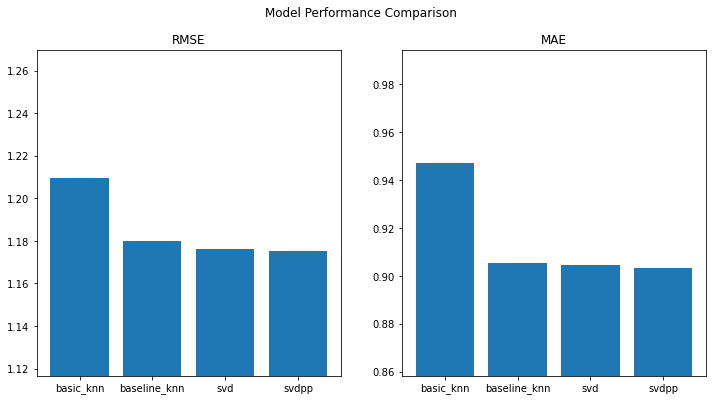

In [20]:
# Define the models

model1 = basic_knn
model2 = base_knn
with open('best_svd_model.pkl', 'rb') as file:
    model3 = pickle.load(file)
with open('best_svdpp_model.pkl', 'rb') as file:
    model4 = pickle.load(file)

models = [model1, model2, model3, model4]

# Initialize arrays to store the results
rmse_means = []
mae_means = []
elapsed_times = []

# Run cross-validation and store results for each model
for model in models:
    start_time = time.time()
    results = cross_validate(model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    elapsed_time = time.time() - start_time

    rmse_means.append(np.mean(results['test_rmse']))
    mae_means.append(np.mean(results['test_mae']))
    elapsed_times.append(elapsed_time)

# Create bar plots
x_labels = ['basic_knn', 'baseline_knn', 'svd', 'svdpp']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Model Performance Comparison')

ax1.bar(x_labels, rmse_means)
ax1.set_title('RMSE')
ax1.set_ylim([min(rmse_means) * 0.95, max(rmse_means) * 1.05])

ax2.bar(x_labels, mae_means)
ax2.set_title('MAE')
ax2.set_ylim([min(mae_means) * 0.95, max(mae_means) * 1.05])

plt.show()
